<a href="https://colab.research.google.com/github/abhiskp/Pneumonia-Detection-in-Children/blob/main/vgg_and_cnn_superimposed(22).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# super imposition

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg19 import VGG19
from keras import optimizers
from keras.utils import to_categorical


In [ ]:
# Set parameters
img_rows, img_cols = 224, 224
batch_size = 32
epochs = 10
lr = 0.0001


In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhiskp","key":"eed4e593d559cc8f4b1d011a8f33db10"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/pediatric-pneumonia-chest-xray

100% 1.14G/1.14G [00:21<00:00, 68.0MB/s]
100% 1.14G/1.14G [00:21<00:00, 56.3MB/s]


In [ ]:
!unzip pediatric-pneumonia-chest-xray.zip

Streaming output truncated to the last 5000 lines.
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0435-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0437-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0438-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0439-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0440-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0441-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0442-

In [ ]:
# Load the dataset
def load_data():
    train_dir = './Pediatric Chest X-ray Pneumonia/train'
    test_dir = './Pediatric Chest X-ray Pneumonia/test'

    # Load train data
    train_normal = [cv2.resize(cv2.imread(os.path.join(train_dir, 'NORMAL', i)),
                    (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
                    for i in os.listdir(os.path.join(train_dir, 'NORMAL'))]
    train_pneumonia = [cv2.resize(cv2.imread(os.path.join(train_dir, 'PNEUMONIA', i)),
                    (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
                    for i in os.listdir(os.path.join(train_dir, 'PNEUMONIA'))]
    X_train = train_normal + train_pneumonia
    y_train = [0]*len(train_normal) + [1]*len(train_pneumonia)

    # Load test data
    test_normal = [cv2.resize(cv2.imread(os.path.join(test_dir, 'NORMAL', i)),
                    (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
                    for i in os.listdir(os.path.join(test_dir, 'NORMAL'))]
    test_pneumonia = [cv2.resize(cv2.imread(os.path.join(test_dir, 'PNEUMONIA', i)),
                    (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
                    for i in os.listdir(os.path.join(test_dir, 'PNEUMONIA'))]
    X_test = test_normal + test_pneumonia
    y_test = [0]*len(test_normal) + [1]*len(test_pneumonia)

    # Convert data to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Shuffle data
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    X_test, y_test = shuffle(X_test, y_test, random_state=42)

    # Convert labels to one-hot encoding
    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data()


In [ ]:
# Define the model
def create_model():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=lr),
                  metrics=['accuracy'])
    return model

model = create_model()


80134624/80134624 [==============================] - 0s 0us/step


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=5,
                    verbose=1, validation_data=(X_test, y_test))

# # Evaluate the model on the test set
# y_pred = model.predict(X_test, batch_size=batch_size)
# fpr, tpr, thresholds = roc_curve(np.argmax(y_test, axis=1), y_pred[:,1])
# roc_auc = auc(fpr, tpr)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)
# cm = confusion_matrix(y_true, y_pred_classes)
# cr = classification_report(y_true, y_pred_classes)
# f1 = f1_score(y_true, y_pred_classes)
# print('AUC: {:.2f}'.format(roc_auc))
# print('F1 Score: {:.2f}'.format(f1))
# print('Confusion Matrix:')
# print(cm)
# print('Classification Report:')
# print(cr)
# # Evaluate the model on the test set
# y_pred = model.predict(X_train, batch_size=batch_size)
# fpr, tpr, thresholds = roc_curve(np.argmax(y_train, axis=1), y_pred[:,1])
# roc_auc = auc(fpr, tpr)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)
# cm = confusion_matrix(y_true, y_pred_classes)
# cr = classification_report(y_true, y_pred_classes)
# f1 = f1_score(y_true, y_pred_classes)
# print('AUC: {:.2f}'.format(roc_auc))
# print('F1 Score: {:.2f}'.format(f1))
# print('Confusion Matrix:')
# print(cm)
# print('Classification Report:')
# print(cr)


Epoch 1/5
164/164 [==============================] - 3936s 24s/step - loss: 0.8115 - accuracy: 0.9446 - val_loss: 3.0825 - val_accuracy: 0.7853
Epoch 2/5
164/164 [==============================] - 3851s 24s/step - loss: 0.1843 - accuracy: 0.9694 - val_loss: 2.9888 - val_accuracy: 0.7580
Epoch 3/5
164/164 [==============================] - 3885s 24s/step - loss: 0.0654 - accuracy: 0.9832 - val_loss: 1.8193 - val_accuracy: 0.7837
Epoch 4/5
164/164 [==============================] - 3892s 24s/step - loss: 0.0309 - accuracy: 0.9876 - val_loss: 2.0931 - val_accuracy: 0.7821
Epoch 5/5
164/164 [==============================] - 3896s 24s/step - loss: 0.0305 - accuracy: 0.9914 - val_loss: 1.4289 - val_accuracy: 0.8381


In [ ]:
# Evaluate the model on the test set
y_pred = model.predict(X_test, batch_size=batch_size)
fpr, tpr, thresholds = roc_curve(np.argmax(y_test, axis=1), y_pred[:,1])
roc_auc = auc(fpr, tpr)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
cr = classification_report(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)
print('AUC: {:.2f}'.format(roc_auc))
print('F1 Score: {:.2f}'.format(f1))
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(cr)


20/20 [==============================] - 420s 21s/step
AUC: 0.96
F1 Score: 0.89
Confusion Matrix:
[[134 100]
 [  1 389]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.57      0.73       234
           1       0.80      1.00      0.89       390

    accuracy                           0.84       624
   macro avg       0.89      0.79      0.81       624
weighted avg       0.87      0.84      0.83       624



In [ ]:
# Evaluate the model on the test set
y_pred = model.predict(X_train, batch_size=batch_size)
fpr, tpr, thresholds = roc_curve(np.argmax(y_train, axis=1), y_pred[:,1])
roc_auc = auc(fpr, tpr)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
cr = classification_report(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)
print('AUC: {:.2f}'.format(roc_auc))
print('F1 Score: {:.2f}'.format(f1))
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(cr)

NameError: ignored

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
input_shape = (224, 224, 3)


In [ ]:
# test_datagen = ImageDataGenerator(rescale=1./255,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# test_generator = test_datagen.flow_from_directory(test_datagen,
#                                                   target_size=(224, 224),
#                                                   batch_size=32,
#                                                   class_mode='categorical')
test_generator = test_datagen.flow_from_directory('./Pediatric Chest X-ray Pneumonia/test',
                                                  target_size=input_shape[:2],
                                                  batch_size=32,
                                                  class_mode='binary')


Found 624 images belonging to 2 classes.


In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc, tp, fp, tn, fn = model.evaluate(test_generator)


ValueError: ignored

In [ ]:
# print(model.evaluate(y_test))
# print(tp)
# print(tn)
# print(fn)
# print(fp)
# print("acc  :"+str(test_accuracy))
# print("precc :"+str(test_precision))
# print("rec: " + str(test_recall))
# print("test_auc : "+ str(test_auc) )

ValueError: ignored

# New Section

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.applications.vgg19 import VGG19

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load data
train_data_dir = './Pediatric Chest X-ray Pneumonia/train'
val_data_dir = './Pediatric Chest X-ray Pneumonia/test'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')


Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Define CNN model
cnn_input = Input(shape=(224, 224, 3))
cnn = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
cnn = tf.keras.layers.MaxPooling2D((2, 2))(cnn)
cnn = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(cnn)
cnn = tf.keras.layers.MaxPooling2D((2, 2))(cnn)
cnn = tf.keras.layers.Flatten()(cnn)
cnn = tf.keras.layers.Dense(64, activation='relu')(cnn)
cnn = tf.keras.layers.Dropout(0.5)(cnn)

# Load pre-trained VGG19 model
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19.trainable = False

# Combine CNN and VGG19 models
x = vgg19.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
combined = tf.keras.layers.concatenate([cnn, x])
output = Dense(1, activation='sigmoid')(combined)
model = Model(inputs=[cnn_input, vgg19.input], outputs=output)

In [ ]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train model
history = model.fit([train_generator.next()[0], train_generator.next()[0]],
                    train_generator.next()[1],
                    batch_size=batch_size,
                    epochs=5,
                    validation_data=([val_generator.next()[0], val_generator.next()[0]], val_generator.next()[1]))


Epoch 1/5
1/1 [==============================] - 76s 76s/step - loss: 0.7210 - accuracy: 0.8125 - val_loss: 0.9950 - val_accuracy: 0.5312
Epoch 2/5
1/1 [==============================] - 71s 71s/step - loss: 0.4608 - accuracy: 0.8125 - val_loss: 0.9680 - val_accuracy: 0.5312
Epoch 3/5
1/1 [==============================] - 64s 64s/step - loss: 0.5475 - accuracy: 0.7500 - val_loss: 1.1514 - val_accuracy: 0.5312
Epoch 4/5
1/1 [==============================] - 64s 64s/step - loss: 0.5349 - accuracy: 0.7500 - val_loss: 1.1648 - val_accuracy: 0.5312
Epoch 5/5
1/1 [==============================] - 64s 64s/step - loss: 0.6129 - accuracy: 0.7812 - val_loss: 1.1211 - val_accuracy: 0.5312


In [ ]:
# Evaluate model
val_pred = model.predict([val_generator.next()[0], val_generator.next()[0]])
val_labels = val_generator.next()[1]

# Compute evaluation metrics
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

auc = roc_auc_score(val_labels, val_pred)
f1 = f1_score(val_labels, np.round(val_pred))
tn, fp, fn, tp = confusion_matrix(val_labels, np.round(val_pred)).ravel()

print('AUC:', auc)
print('F1 Score:', f1)
print('True Negative:', tn)
print('False Positive:', fp)
print('False Negative:', fn)

1/1 [==============================] - 23s 23s/step
AUC: 0.26587301587301587
F1 Score: 0.72
True Negative: 0
False Positive: 14
False Negative: 0


In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc, tp, fp, tn, fn = model.evaluate(test_generator)


ValueError: ignored

## New Section2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.applications.vgg19 import VGG19

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load data
train_data_dir = './Pediatric Chest X-ray Pneumonia/train'
val_data_dir = './Pediatric Chest X-ray Pneumonia/test'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')

# Define CNN model
cnn_input = Input(shape=(224, 224, 3))
cnn = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
cnn = tf.keras.layers.MaxPooling2D((2, 2))(cnn)
cnn = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(cnn)
cnn = tf.keras.layers.MaxPooling2D((2, 2))(cnn)
cnn = tf.keras.layers.Flatten()(cnn)
cnn = tf.keras.layers.Dense(64, activation='relu')(cnn)
cnn = tf.keras.layers.Dropout(0.5)(cnn)

# Load pre-trained VGG19 model
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19.trainable = False

# Combine CNN and VGG19 models
x = vgg19.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
combined = tf.keras.layers.concatenate([cnn, x])
output = Dense(1, activation='sigmoid')(combined)
model = Model(inputs=[cnn_input, vgg19.input], outputs=output)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit([train_generator.next()[0], train_generator.next()[0]],
                    train_generator.next()[1],
                    batch_size=batch_size,
                    epochs=5,
                    validation_data=([val_generator.next()[0], val_generator.next()[0]], val_generator.next()[1]))





Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
1/1 [==============================] - 52s 52s/step - loss: 0.7463 - accuracy: 0.5000 - val_loss: 1.0525 - val_accuracy: 0.6250
Epoch 2/10
1/1 [==============================] - 65s 65s/step - loss: 0.8413 - accuracy: 0.6875 - val_loss: 0.9726 - val_accuracy: 0.6250
Epoch 3/10
1/1 [==============================] - 65s 65s/step - loss: 0.8600 - accuracy: 0.6875 - val_loss: 0.7305 - val_accuracy: 0.6250
Epoch 4/10
1/1 [==============================] - 65s 65s/step - loss: 0.6999 - accuracy: 0.7188 - val_loss: 0.6868 - val_accuracy: 0.5938
Epoch 5/10
1/1 [==============================] - 65s 65s/step - loss: 0.6660 - accuracy: 0.6250 - val_loss: 0.7204 - val_accuracy: 0.4375
Epoch 6/10
1/1 [==============================] - 65s 65s/step - loss: 0.5858 - accuracy: 0.7500 - val_loss: 0.6960 - val_accuracy: 0.5312
Epoch 7/10
1/1 [==============================] - 65s 65s/step - loss: 0.8068 - acc

In [ ]:
# Evaluate model
val_pred = model.predict([val_generator.next()[0], val_generator.next()[0]])
val_labels = val_generator.next()[1]

# Compute evaluation metrics
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

auc = roc_auc_score(val_labels, val_pred)
f1 = f1_score(val_labels, np.round(val_pred))
tn, fp, fn, tp = confusion_matrix(val_labels, np.round(val_pred)).ravel()


1/1 [==============================] - 25s 25s/step


In [ ]:
print('AUC:', auc)
print('F1 score:', f1)
print('True positive:', tp)
print('True negative:', tn)
print('False positive:', fp)
print('False negative:', fn)

AUC: 0.6
F1 score: 0.6938775510204082
True positive: 17
True negative: 0
False positive: 15
False negative: 0


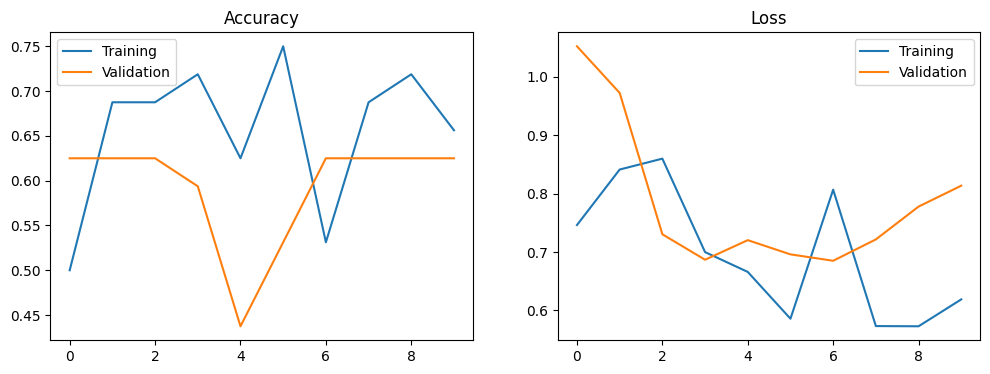

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.lineplot(x=history.epoch, y=history.history['accuracy'], ax=ax[0], label='Training')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], ax=ax[0], label='Validation')
ax[0].set_title('Accuracy')
ax[0].legend()

sns.lineplot(x=history.epoch, y=history.history['loss'], ax=ax[1], label='Training')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], ax=ax[1], label='Validation')
ax[1].set_title('Loss')
ax[1].legend()

plt.show()

# New Section3

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

# Set the input shape and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Define the data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('./Pediatric Chest X-ray Pneumonia/train', target_size=input_shape[:2], batch_size=batch_size, class_mode='binary')
val_generator = val_datagen.flow_from_directory('./Pediatric Chest X-ray Pneumonia/test', target_size=input_shape[:2], batch_size=batch_size, class_mode='binary')

# Load the ImageNet pre-trained model and remove the top layer
base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output

# Add a global average pooling layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add a fully-connected layer with 512 hidden units and ReLU activation
x = keras.layers.Dense(512, activation='relu')(x)

# Add a dropout layer with a rate of 0.5
x = keras.layers.Dropout(0.5)(x)

# Add a sigmoid output layer for binary classification
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

# Combine the base model and the top layers
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])



# # Add custom layers for classification
# x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(rate=0.25)(x)
# x = Flatten()(x)
# x = Dense(units=64, activation='relu')(x)
# x = Dropout(rate=0.5)(x)
# predictions = Dense(units=1, activation='sigmoid')(x)

# # Combine the base model and the custom layers
# model = Model(inputs=base_model.input, outputs=predictions)


Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Train the model
history = model.fit(train_generator, epochs=5, validation_data=val_generator)

# Evaluate the model on the test set


Epoch 1/5
164/164 [==============================] - 739s 4s/step - loss: 0.3540 - accuracy: 0.8679 - val_loss: 0.4859 - val_accuracy: 0.8093
Epoch 2/5
164/164 [==============================] - 717s 4s/step - loss: 0.2056 - accuracy: 0.9192 - val_loss: 0.4355 - val_accuracy: 0.8205
Epoch 3/5
164/164 [==============================] - 728s 4s/step - loss: 0.1926 - accuracy: 0.9224 - val_loss: 0.4956 - val_accuracy: 0.8269
Epoch 4/5
164/164 [==============================] - 713s 4s/step - loss: 0.1793 - accuracy: 0.9262 - val_loss: 0.4962 - val_accuracy: 0.8173
Epoch 5/5
20/20 [==============================] - 72s 3s/step


TypeError: ignored

In [ ]:

# Plot accuracy and loss curves
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.lineplot(x=history.epoch, y=history.history['accuracy'], ax=ax[0], label='Training')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], ax=ax[0], label='Validation')
ax[0].set_title('Accuracy')
ax[0].legend()

sns.lineplot(x=history.epoch, y=history.history['loss'], ax=ax[1], label='Training')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], ax=ax


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)

# Make predictions on the test set
y_pred = model.predict(test_generator).flatten()

# Compute evaluation metrics
fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred)
# auc_score = auc(fpr, tpr)
f1_score = f1_score(test_generator.classes, y_pred.round())
tn, fp, fn, tp = confusion_matrix(test_generator.classes, y_pred.round()).ravel()

# Print the evaluation metrics
# print('AUC: {:.4f}'.format(auc_score))
print('F1 score: {:.4f}'.format(f1_score))
print('True positives: {}'.format(tp))
print('True negatives: {}'.format(tn))
print('False positives: {}'.format(fp))
print('False negatives: {}'.format(fn))

20/20 [==============================] - 72s 4s/step
F1 score: 0.6611
True positives: 276
True negatives: 65
False positives: 169
False negatives: 114
